# Fine Tuning Bert for second dataset

<a id='section01'></a>
### Импорт библиотек

In [ ]:
!pip install transformers
!pip install sklearn
!pip install torch
!pip install comet-ml
!pip install numpy
!pip install pandas

In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import comet_ml
from comet_ml import Experiment

import transformers
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
from torch import cuda
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

<a id='section02'></a>
### Инициализация функций

In [3]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

In [4]:
def statistic(y_pred_test, y_test, y_pred_train, y_train,
             t1, t2):
    score_table = pd.DataFrame(columns=(t1, t2))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [5]:
def set_experiment(api_key, project_name, workspace):
    experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace
)
    
    return experiment

In [6]:
def log_parameters(experiment, hyper_params):
    experiment.log_parameter("train_batch_size", hyper_params['batch_size'])
    experiment.log_parameter("test_batch_size", hyper_params['batch_size'])

    experiment.log_parameter("Learning Rate", hyper_params['lr'])
    experiment.log_parameter("general_epochs", hyper_params['epochs'])
    experiment.log_parameter("max_len", hyper_params['max_len'])

In [7]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = dataframe.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
class BertClassifier(nn.Module):

    def __init__(self, freeze_bert=False):
        
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids):

        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
api_key = ххх
project_name = ххх
workspace = ххх

experiment = set_experiment(api_key, project_name, workspace)

In [10]:
device = 'cuda' if cuda.is_available() else 'cpu'

<a id='section03'></a>
### Работа с данными

In [11]:
X_train = pd.read_csv('train_second.csv', header=0)
X_dev = pd.read_csv('dev_second.csv', header=0)
X_test = pd.read_csv('test_second.csv', header=0)

X_rusenti_test = pd.read_csv('test_first.csv', header=0)
X_rusenti_test.drop(['id'], inplace=True, axis=1)

<a id='section04'></a>
### Подготовка dataloader

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

parameters = {
    'batch_size': 32,
    'lr': 5e-5,
    'epochs': 5,
    'max_len': 256,
}

log_parameters(experiment, parameters)

In [13]:
print("TRAIN Dataset: {}".format(X_train.shape))
print("DEV Dataset: {}".format(X_dev.shape))
print("TEST RUSENTI Dataset: {}".format(X_rusenti_test.shape))
print("TEST Dataset: {}".format(X_test.shape))

training_set = CustomDataset(X_train, tokenizer, parameters['max_len'])
dev_set = CustomDataset(X_dev, tokenizer, parameters['max_len'])
testing_set = CustomDataset(X_test, tokenizer, parameters['max_len'])
rusenti_testing_set = CustomDataset(X_rusenti_test, tokenizer, parameters['max_len'])

TRAIN Dataset: (12542, 2)
DEV Dataset: (3136, 2)
TEST RUSENTI Dataset: (1143, 2)
TEST Dataset: (6720, 2)


In [14]:
train_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': parameters['batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
dev_loader = DataLoader(dev_set, **test_params)
testing_loader = DataLoader(testing_set, **test_params)
testing_rusenti_loader = DataLoader(rusenti_testing_set, **test_params)

<a id='section05'></a>
### Fine Tuning

In [ ]:
bert_classifier = BertClassifier(freeze_bert=False)
bert_classifier.to(device)

experiment.set_model_graph(bert_classifier, True)

optimizer = AdamW(bert_classifier.parameters(),
                      lr=parameters['lr'],
                      eps=1e-8 
                      )

total_steps = len(training_loader) * parameters['epochs']

scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

In [17]:
import time
from copy import deepcopy 

loss_fn = nn.CrossEntropyLoss()
global_balanced_acc = 0
best_model_params = deepcopy(bert_classifier.state_dict())

step = 0

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, data in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)
        
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(ids, mask, token_type_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                
                experiment.log_metric('loss_train_steps', batch_loss / batch_counts)
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        experiment.log_metric('loss_train', avg_train_loss)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    
    global global_balanced_acc, step

    model.eval()

    val_accuracy = []
    val_loss = []
    
    all_preds = []
    all_labels = []

    for data in val_dataloader:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        b_labels = data['targets'].to(device, dtype = torch.long)
        
        with torch.no_grad():
            logits = model(ids, mask, token_type_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()
        
        all_preds += preds.tolist()
        all_labels += b_labels.tolist()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    experiment.log_metric('loss_val', val_loss)
    
    b_accuracy = balanced_accuracy_score(all_labels, all_preds)
    print('Balanced_accuracy know: ', b_accuracy)
    experiment.log_metric('loss_b_accuracy', b_accuracy)
    
    if b_accuracy > global_balanced_acc:
        global_balanced_acc = b_accuracy
        best_model_params = deepcopy(model.state_dict())
        
        output_model_file = f'second_bert_sentiment_{round(b_accuracy, 5)}_{step}.bin'

        model_to_save = model
        torch.save(model_to_save, output_model_file)

    return val_loss, val_accuracy

In [18]:
train(bert_classifier, training_loader, dev_loader, epochs=parameters['epochs'], evaluation=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   100   |   0.137400   |     -      |     -     |  142.07  
   1    |   200   |   0.024340   |     -      |     -     |  138.43  
   1    |   300   |   0.011521   |     -      |     -     |  137.67  
   1    |   391   |   0.008651   |     -      |     -     |  125.45  
----------------------------------------------------------------------
Balanced_accuracy know:  0.9993164730006836
   1    |    -    |   0.046558   |  0.004025  |   99.94   |  606.42  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   100   |   0.011363   |     -      |     -     |  139.65  
   2    |   200   |   0.004621   |     -      |     -     |  138.03  
   2    |   300   |  

<a id='section06'></a>
### Результаты

In [19]:
def get_predicts(model, loader, _type_):
    
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds, all_labels = [], []
    
    
    with torch.no_grad():
        for _, data in (enumerate(loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)
            preds = torch.argmax(logits, dim=1).flatten()

            all_preds += preds.tolist()
            all_labels += b_labels.tolist()

    
    return all_preds, all_labels


In [21]:
model = torch.load('/content/second_bert_sentiment_1.0_0.bin')

model.eval()
None

In [22]:
y_pred_test, y_test = get_predicts(model, testing_loader, 'Test')
y_pred_train, y_train = get_predicts(model, training_loader, 'Train')
y_pred_val, y_val = get_predicts(model, dev_loader, 'Validation')

y_pred_senti, y_senti = get_predicts(model, testing_rusenti_loader, 'Test_senti')

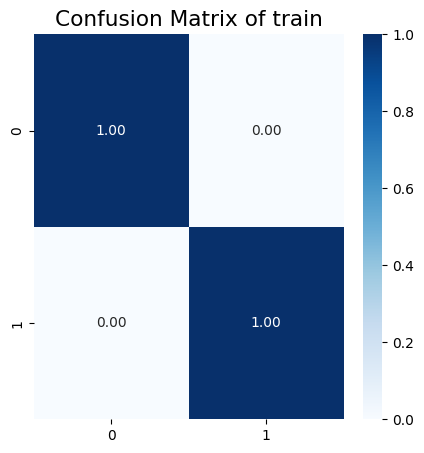

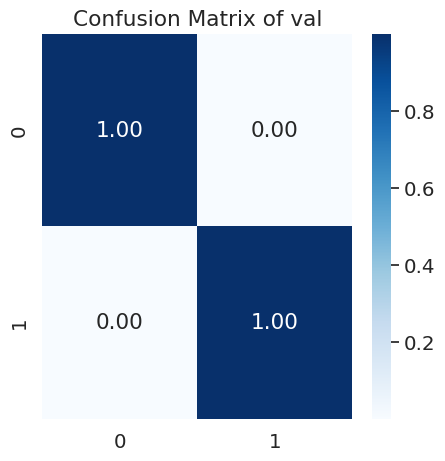

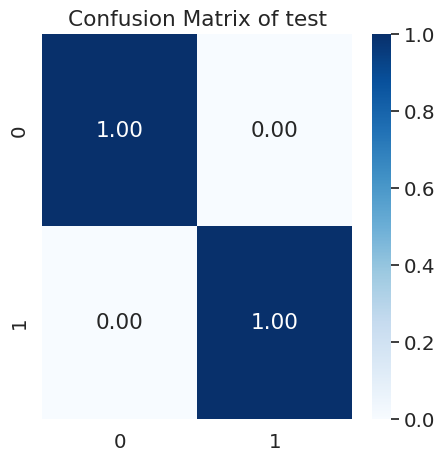

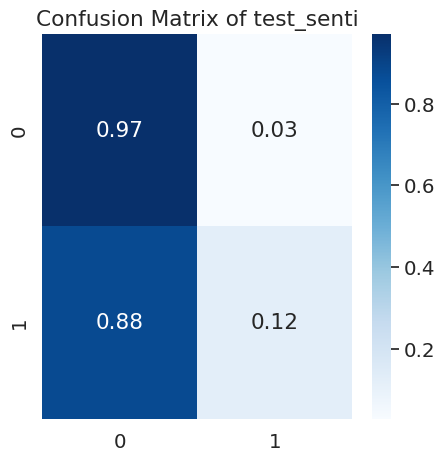

In [23]:
cm_plot(y_train, y_pred_train, 'train')
cm_plot(y_val, y_pred_val, 'val')
cm_plot(y_test, y_pred_test, 'test')

cm_plot(y_senti, y_pred_senti, 'test_senti')

In [24]:
statistic(y_pred_test, y_test, y_pred_train, y_train, 'train', 'test')

,train,test
balanced_accuracy_score,0.999829,0.999522
accuracy_score,0.999841,0.999554
f1 weighted,0.999841,0.999554
f1 micro,0.999841,0.999554
f1 macro,0.99984,0.999552


In [25]:
statistic(y_pred_senti, y_senti, y_pred_val, y_val, 'test_senti', 'dev')

,test_senti,dev
balanced_accuracy_score,0.999359,0.546683
accuracy_score,0.999362,0.612423
f1 weighted,0.999362,0.518021
f1 micro,0.999362,0.612423
f1 macro,0.999359,0.476764


In [26]:
from google.colab import files
from google.colab import drive

drive.mount("/content/gdrive/")

!cp second_bert_sentiment_1.0_0.bin ххх

Mounted at /content/gdrive/
